In [33]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.colors as colors
import pandas as pd
from scipy.stats import norm, chi2
from tqdm import tqdm


# NEW: we will use ks_2samp for a simple statistical test on Kd distributions
from scipy.stats import ks_2samp

# define matplotlib style
mpl.style.use("classic")
mpl.rc("xtick", labelsize=15)
mpl.rc("ytick", labelsize=15)
mpl.rc("xtick.major", size=14, width=2)
mpl.rc("xtick.minor", size=7, width=2, visible=True)
mpl.rc("ytick.major", size=14, width=2)
mpl.rc("ytick.minor", size=7, width=2, visible=True)
mpl.rc("lines", linewidth=2, markersize=5)
mpl.rc("axes", linewidth=2, labelsize=15, labelpad=2.5)
mpl.rc("legend", fontsize=15, loc="best", frameon=True, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [9]:
import params, utils
from models import mlp, gnn
from modules import helpers, training, fitting

import importlib

importlib.reload(params)
importlib.reload(utils)

importlib.reload(training)
importlib.reload(fitting)

importlib.reload(mlp)
importlib.reload(gnn)

<module 'models.gnn' from '/Users/yongao/Desktop/8.13/mit-jlab-sp25/higgs/analysis/models/gnn.py'>

In [10]:
## some scale factors and constant you might use

## mass square of muon: m_muon^2 (in GeV)
sqm1 = (0.105658) * (0.105658)
## mass square of electron: m_e^2 (in GeV)
sqme = (0.0005109989) * (0.0005109989)
## mass of Z boson (in GeV)
mZ = 91.1876


## constants for the scale factor of MC. The MC is produced at a certain cross section\
## with certain number of events. To increase statistics, the event numbers generated are usually very large,\
## therefore a scale factor is needed to apply on the MC to make them agree with data.
## Scale factor for each MC component is: lumi * xsec / nevt, as provided below

## Luminosity of each year
lumi12 = 11580.
lumi11 = 2330.

## MC cross section of each process
xsecZZ412 = 0.107
xsecZZ2mu2e12 = 0.249
xsecZZ411 = 0.093
xsecZZ2mu2e11 = 0.208

xsecTTBar12 = 200.
xsecTTBar11 = 19.504

xsecDY5012 = 2955.
xsecDY1012 = 10.742
xsecDY5011 = 2475.
xsecDY1011 = 9507.
  
scalexsecHZZ12 = 0.0065
scalexsecHZZ11 = 0.0057

## Number of MC Events generated for each process
nevtZZ4mu12 = 1499064
nevtZZ4e12 = 1499093
nevtZZ2mu2e12 = 1497445
nevtHZZ12 = 299973 
nevtTTBar12 = 6423106
nevtDY5012 = 29426492
nevtDY1012 = 6462290
  
nevtZZ4mu11 = 1447136
nevtZZ4e11 = 1493308
nevtZZ2mu2e11 = 1479879
nevtHZZ11 = 299683
nevtTTBar11 = 9771205
nevtDY5011 = 36408225
nevtDY1011 = 39909640


labels = ['$m_{H}$ = 125 GeV', r'ZZ $\rightarrow$ 4l', 'Z/$\gamma^{*}$ + X', r'$t\bar{t}$']
colors = ['r','b','g','gray']
scales_higgs = [lumi11*scalexsecHZZ11/nevtHZZ11, lumi12*scalexsecHZZ12/nevtHZZ12]
scales_zz = [lumi11*xsecZZ411/nevtZZ4mu11, lumi11*xsecZZ2mu2e11/nevtZZ2mu2e11, lumi11*xsecZZ411/nevtZZ4e11,\
             lumi12*xsecZZ412/nevtZZ4mu12, lumi12*xsecZZ2mu2e12/nevtZZ2mu2e12, lumi12*xsecZZ412/nevtZZ4e12]
scales_dy = [lumi11*xsecDY1011/nevtDY1011, lumi11*xsecDY5011/nevtDY5011, \
             lumi12*xsecDY1012/nevtDY1012, lumi11*xsecDY5012/nevtDY5012]
scales_tt = [lumi11*xsecTTBar11/nevtTTBar11, lumi12*xsecTTBar12/nevtTTBar12]

In [11]:
### open the files ###
# read datalist of each year and combine to one 
data_year  = [pd.read_csv('../HiggsTo4L/data/clean_data_2011.csv',index_col=None, header=0)]
data_year += [pd.read_csv('../HiggsTo4L/data/clean_data_2012.csv',index_col=None, header=0)]
data = pd.concat(data_year,axis=0,ignore_index=True)


# read MClist of each process and each year
mc_higgs_11 = pd.read_csv('../HiggsTo4L/MC/higgs2011.csv',index_col=None, header=0)
mc_higgs_12 = pd.read_csv('../HiggsTo4L/MC/higgs2012.csv',index_col=None, header=0)
## ZZ*
mc_zz4mu_11 = pd.read_csv('../HiggsTo4L/MC/zzto4mu2011.csv',index_col=None, header=0)
mc_zz2mu2e_11 = pd.read_csv('../HiggsTo4L/MC/zzto2mu2e2011.csv',index_col=None, header=0)
mc_zz4e_11 = pd.read_csv('../HiggsTo4L/MC/zzto4e2011.csv',index_col=None, header=0)

mc_zz4mu_12 = pd.read_csv('../HiggsTo4L/MC/zzto4mu2012.csv',index_col=None, header=0)
mc_zz2mu2e_12 = pd.read_csv('../HiggsTo4L/MC/zzto2mu2e2012.csv',index_col=None, header=0)
mc_zz4e_12 = pd.read_csv('../HiggsTo4L/MC/zzto4e2012.csv',index_col=None, header=0)
## Drell-Yan
mc_dy10_11 = pd.read_csv('../HiggsTo4L/MC/dy1050_2011.csv',index_col=None, header=0)
mc_dy50_11 = pd.read_csv('../HiggsTo4L/MC/dy50_2011.csv',index_col=None, header=0)
mc_dy10_12 = pd.read_csv('../HiggsTo4L/MC/dy1050_2012.csv',index_col=None, header=0)
mc_dy50_12 = pd.read_csv('../HiggsTo4L/MC/dy50_2012.csv',index_col=None, header=0)
## ttbar
mc_ttbar_11 = pd.read_csv('../HiggsTo4L/MC/ttbar2011.csv',index_col=None, header=0)
mc_ttbar_12 = pd.read_csv('../HiggsTo4L/MC/ttbar2012.csv',index_col=None, header=0)


# creat a combined list of MC to study the shape
mc_higgs = [mc_higgs_11, mc_higgs_12]
mc_zz = [mc_zz4mu_11, mc_zz2mu2e_11, mc_zz4e_11, mc_zz4mu_12, mc_zz2mu2e_12, mc_zz4e_12]
mc_dy = [mc_dy10_11, mc_dy50_11, mc_dy10_12, mc_dy50_12]
mc_tt = [mc_ttbar_11, mc_ttbar_12]

mc_sig = pd.concat(mc_higgs,axis=0,ignore_index=True)
mc_bkg_zz = pd.concat(mc_zz,axis=0,ignore_index=True)
mc_bkg_dy = pd.concat(mc_dy,axis=0,ignore_index=True)
mc_bkg_tt = pd.concat(mc_tt,axis=0,ignore_index=True)

## For Selections:
mc_all = [mc_higgs, mc_zz, mc_dy, mc_tt]

In [12]:
#This is the header of the csv file:
#Run,Event,PID1,Q1,E1,px1,py1,pz1,eta1,phi1,PID2,Q2,E2,px2,py2,pz2,eta2,phi2,PID3,Q3,E3,px3,py3,pz3,eta3,phi3,PID4,Q4,E4,px4,py4,pz4,eta4,phi4
def ReadEntries(lis):
    return lis['PID1'],lis['Q1'],lis['E1'],lis['px1'],lis['py1'],lis['pz1'],lis['eta1'],lis['phi1'], \
    lis['PID2'],lis['Q2'],lis['E2'],lis['px2'],lis['py2'],lis['pz2'],lis['eta2'],lis['phi2'], \
    lis['PID3'],lis['Q3'],lis['E3'],lis['px3'],lis['py3'],lis['pz3'],lis['eta3'],lis['phi3'], \
    lis['PID4'],lis['Q4'],lis['E4'],lis['px4'],lis['py4'],lis['pz4'],lis['eta4'],lis['phi4']

def pt(px, py):
    return np.sqrt(px**2 + py**2)

def invMass(E, px, py, pz):
    return np.sqrt(E**2 - (px**2 + py**2 + pz**2))

def InvMass_4l(lists):   ### faster way to get the 4l-system invMass directly from the list, as you may repeately run it for the final plot###
    E_tot = lists['E1'] + lists['E2'] + lists['E3'] + lists['E4']
    px_tot = lists['px1'] + lists['px2'] + lists['px3'] + lists['px4']
    py_tot = lists['py1'] + lists['py2'] + lists['py3'] + lists['py4']
    pz_tot = lists['pz1'] + lists['pz2'] + lists['pz3'] + lists['pz4']
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

In [13]:
def PlotShape(variable, rmin, rmax, nbins):
    for i,var in enumerate(variable):
        hist, bins = np.histogram(var, bins = nbins, range = (rmin,rmax))
        bincenter = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bincenter, hist * (1./len(var)), color = colors[i], label=labels[i])
    plt.legend(fontsize = 10)

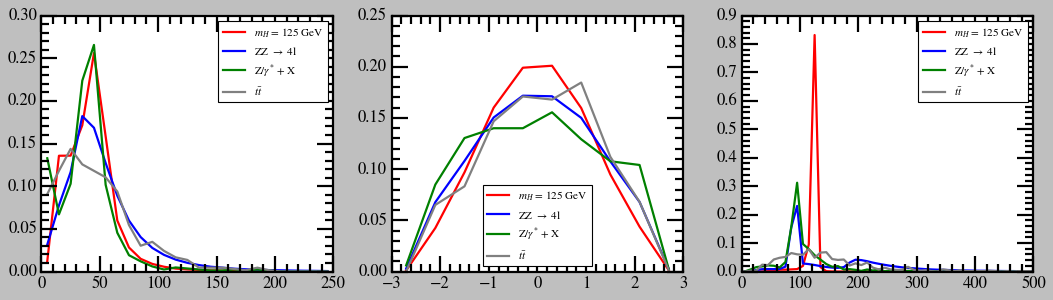

In [14]:
pt1_sig = pt(mc_sig['px1'], mc_sig['py1'])
pt1_bkg_zz = pt(mc_bkg_zz['px1'], mc_bkg_zz['py1'])
pt1_bkg_dy = pt(mc_bkg_dy['px1'], mc_bkg_dy['py1'])
pt1_bkg_tt = pt(mc_bkg_tt['px1'], mc_bkg_tt['py1'])

pt1 = [pt1_sig,pt1_bkg_zz,pt1_bkg_dy,pt1_bkg_tt]
eta1 = [mc_sig['eta1'], mc_bkg_zz['eta1'], mc_bkg_dy['eta1'], mc_bkg_tt['eta1']]
invM4l = [InvMass_4l(mc_sig),InvMass_4l(mc_bkg_zz),InvMass_4l(mc_bkg_dy),InvMass_4l(mc_bkg_tt)]

plt.figure(figsize = (16,4))
plt.subplot(1, 3, 1)
PlotShape(pt1, 0, 250, 25)
plt.subplot(1, 3, 2)
PlotShape(eta1, -3, 3, 10)
plt.subplot(1, 3, 3)
PlotShape(invM4l, 0, 500, 50)

In [15]:
def obj(pid,px,py,eta):  ## object selection for a single object
    pt_obj = pt(px,py)
    if (np.abs(pid) == 13 and pt_obj > 5.) or (np.abs(pid) == 11 and pt_obj > 7.):
        if (np.abs(pid) == 13 and np.abs(eta) < 2.4) or (np.abs(pid) == 11 and np.abs(eta) < 2.5):
            return 1
    #if (np.abs(pid) == 13 and pt_obj > 5. and ...) or (np.abs(pid) == 11 and pt_obj > 7. and ...):
    else:
        return 0
    
    
def objsel(lis):  ## Creat an column to the dataset indicating whether this event passes the object selection
    pass_obj = []
    for row in lis.itertuples():   ## loop over each event(each row)
        pass_obj.append(obj(row.PID1,row.px1,row.py1,row.eta1) and obj(row.PID2,row.px2,row.py2,row.eta2) and obj(row.PID3,row.px3,row.py3,row.eta3) and obj(row.PID4,row.px4,row.py4,row.eta4))
    lis['PassObj'] = pass_obj       

In [16]:
def z_window_twopairs(mass1, mass2, lower1=40, upper1=100, lower2=12, upper2=100):
    '''Z boson mass window for two pairs'''
    # Determine which mass is closer to mZ
    if abs(mass1 - mZ) <= abs(mass2 - mZ):
        z1_mass = mass1
        z2_mass = mass2
    else:
        z1_mass = mass2
        z2_mass = mass1
    
    # Check if both masses are within their respective windows
    if (z1_mass > lower1 and z1_mass < upper1) and (z2_mass > lower2 and z2_mass < upper2):
        return 1
    else:
        return 0

    

    

def evt(PID1,Q1,E1,px1,py1,pz1,PID2,Q2,E2,px2,py2,pz2,PID3,Q3,E3,px3,py3,pz3,PID4,Q4,E4,px4,py4,pz4):

    if(PID1+PID2+PID3+PID4 != 0):    ### charge conservation and lepton flavor conservation
        return 0
    
    #########################################
    ########## More Selections ##############
    #########################################
    
    pt1 = pt(px1,py1)
    pt2 = pt(px2,py2)
    pt3 = pt(px3,py3)
    pt4 = pt(px4,py4)

    if(PID1 != PID2 and PID1 != PID3 and PID1 != PID4): ### 2mu2e event, only one combination
        m_z1 = np.sqrt((E1+E2)**2 - ((px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2))
        m_z2 = np.sqrt((E3+E4)**2 - ((px3+px4)**2 + (py3+py4)**2 + (pz3+pz4)**2))
        ### More Selections ####
        ### If XXX return 1...##
        return z_window_twopairs(m_z1, m_z2)
        ########################
    else: ### 4mu or 4e event, 3 different combination
        ##c1
        m_z1_c1 = np.sqrt((E1+E2)**2 - ((px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2))
        m_z2_c1 = np.sqrt((E3+E4)**2 - ((px3+px4)**2 + (py3+py4)**2 + (pz3+pz4)**2))
        ##c2
        m_z1_c2 = np.sqrt((E1+E3)**2 - ((px1+px3)**2 + (py1+py3)**2 + (pz1+pz3)**2))
        m_z2_c2 = np.sqrt((E2+E4)**2 - ((px2+px4)**2 + (py2+py4)**2 + (pz2+pz4)**2))
        ##c3
        m_z1_c3 = np.sqrt((E1+E4)**2 - ((px1+px4)**2 + (py1+py4)**2 + (pz1+pz4)**2))
        m_z2_c3 = np.sqrt((E2+E3)**2 - ((px2+px3)**2 + (py2+py3)**2 + (pz2+pz3)**2))
        ################# More Selections ###########################################
        ### among the 3 combination based on charge and mass to mass of the Z boson##
        #############################################################################
        return z_window_twopairs(m_z1_c1, m_z2_c1) or z_window_twopairs(m_z1_c2, m_z2_c2) or z_window_twopairs(m_z1_c3, m_z2_c3)



        


def evtsel(lis):   ### Similar as the Function: objsel shown above
    pass_evt = []
    for row in lis.itertuples():
        pass_evt.append(evt(row.PID1,row.Q1,row.E1,row.px1,row.py1,row.pz1,\
                            row.PID2,row.Q2,row.E2,row.px2,row.py2,row.pz2,\
                            row.PID3,row.Q3,row.E3,row.px3,row.py3,row.pz3,\
                            row.PID4,row.Q4,row.E4,row.px4,row.py4,row.pz4))
    lis['PassEvt'] = pass_evt

In [17]:
# ---------------------------
# NEW: Example Kd calculation
# ---------------------------
def KdCalc(E1, px1, py1, pz1,
           E2, px2, py2, pz2,
           E3, px3, py3, pz3,
           E4, px4, py4, pz4):
    """
    Placeholder for your actual Kd formula.

    For illustration, we’ll define a *fake* Kd that depends on
    the total pT of the 4l system. Replace with the correct formula
    or matrix-element approach as needed.
    """
    # 4-vector sums
    E_tot = E1 + E2 + E3 + E4
    px_tot = px1 + px2 + px3 + px4
    py_tot = py1 + py2 + py3 + py4
    pz_tot = pz1 + pz2 + pz3 + pz4
    
    # Fake "discriminant" based on total pT or something else
    pT_4l = np.sqrt(px_tot**2 + py_tot**2)
    # You might do a ratio-based or ME-based approach. For example:
    # kd = Dsig / (Dsig + Dbkg), etc.
    kd = pT_4l / (E_tot + 1e-6)  # Just a toy example
    return kd

def addKdColumn(lis):
    kd_vals = []
    for row in lis.itertuples():
        kd = KdCalc(row.E1, row.px1, row.py1, row.pz1,
                    row.E2, row.px2, row.py2, row.pz2,
                    row.E3, row.px3, row.py3, row.pz3,
                    row.E4, row.px4, row.py4, row.pz4)
        kd_vals.append(kd)
    lis["Kd"] = kd_vals

In [18]:
### Apply object selection and event selection to data and each MC process###
print('Original data shape:',data.shape[0])
objsel(data)
evtsel(data)
# print(data)
print('After object selection',data.query('PassObj == 1').shape[0])
data = data.query('PassObj == 1 and PassEvt == 1')
print('After object and event selection',data.shape[0])

# addKdColumn(data)


for i,bkg in enumerate(mc_all):
    for j,pro in enumerate(bkg):
        print('Processing MC:',labels[i], 'Year:', 2011 + j)
        print('Original MC shape:',pro.shape[0])
        objsel(pro)
        evtsel(pro)
        print('After object selection',pro.query('PassObj == 1').shape[0])
        mc_all[i][j] = pro.query('PassObj == 1 and PassEvt == 1')
        print('After object and event selection',mc_all[i][j].shape[0])

        # addKdColumn(mc_all[i][j])

Original data shape: 2724
After object selection 989
After object and event selection 370
Processing MC: $m_{H}$ = 125 GeV Year: 2011
Original MC shape: 52248
After object selection 45399
After object and event selection 41989
Processing MC: $m_{H}$ = 125 GeV Year: 2012
Original MC shape: 40530
After object selection 36676
After object and event selection 34111
Processing MC: ZZ $\rightarrow$ 4l Year: 2011
Original MC shape: 209504
After object selection 162855
After object and event selection 128842
Processing MC: ZZ $\rightarrow$ 4l Year: 2012
Original MC shape: 155454
After object selection 112091
After object and event selection 64121
Processing MC: ZZ $\rightarrow$ 4l Year: 2013
Original MC shape: 144999
After object selection 95762
After object and event selection 79363
Processing MC: ZZ $\rightarrow$ 4l Year: 2014
Original MC shape: 183843
After object selection 149413
After object and event selection 119968
Processing MC: ZZ $\rightarrow$ 4l Year: 2015
Original MC shape: 124496

In [19]:
def HistInvMass4l(lis, scales, rmin, rmax, nbins):
    hist_lis = []
    for i,pro in enumerate(lis):
        invM = InvMass_4l(pro)
        hist, bins = np.histogram(invM, bins = nbins, range = (rmin,rmax))
        hist = hist * scales[i]
        hist_lis.append(hist)
    return sum(hist_lis)

In [20]:
rmin = 50
rmax = 200
nbins = 54


hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

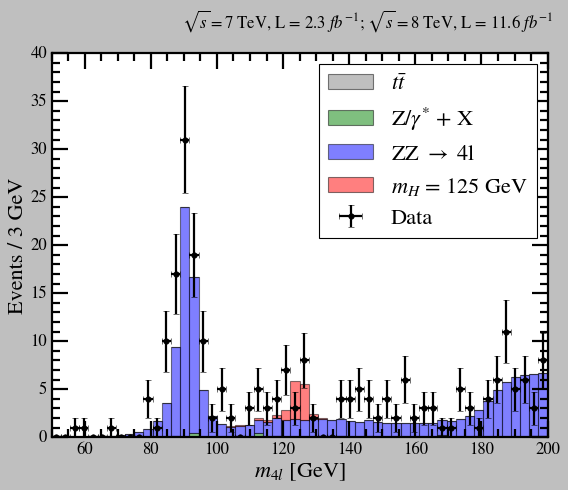

In [22]:
## Now Plot it!!!

plt.figure(figsize = (8,6))


## data
inM_data = InvMass_4l(data)
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:])


## MC
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



# Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = 'Data')



plt.title('$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$ \n', fontsize = 15, position=(0.64,0.95))
plt.xlabel('$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel('Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(rmin,rmax)
plt.legend(fontsize = 20)

plt.show()

In [42]:
nn_zz_hist = hist_mc[2]
nn_higgs_hist = hist_mc[3]
bin_centers = bincenter
nn_observed_hist = hist

def f_ZZ(bin_indices, b):
    return b / np.sum(nn_zz_hist) * nn_zz_hist[bin_indices]

def f_Higgs(bin_indices, s, mH, sigma_mH):
    P_Higgs = norm.cdf(bins,loc=mH,scale=sigma_mH)
    return s * np.diff(P_Higgs)[bin_indices]

In [43]:
b = np.sum(nn_zz_hist)
sigma_mH = 1.2

In [44]:
class ZZFitter(fitting.BasePoissonFitter):
    def __init__(self,
                 bin_indices=np.arange(bin_centers.shape[0]),
                 counts=nn_observed_hist,
                 b=None):
        super().__init__(bin_indices,counts)

        self.b = b

    def _get_initial_guess(self):
        return [50]
    
    def _get_model(self, x, params):
        b = params[0]

        if self.b:
            b = self.b

        return f_ZZ(x,b)
    
class HiggsFitter(fitting.BasePoissonFitter):
    def __init__(self,
                 bin_indices=np.arange(bin_centers.shape[0]),
                 counts=nn_observed_hist,
                 b=None,
                 mH=None,
                 sigma_mH=None):
        super().__init__(bin_indices,counts)

        self.b = b
        self.mH = mH
        self.sigma_mH = sigma_mH

    def _get_initial_guess(self):
        return [50,10,125,1]
    
    def _get_model(self, x, params):
        b, s, mH, sigma_mH = params

        if self.b:
            b = self.b
        if self.mH:
            mH = self.mH
        if self.sigma_mH:
            sigma_mH = self.sigma_mH

        return f_ZZ(x,b) + f_Higgs(x,s,mH,sigma_mH)

In [45]:
zz_fitter = ZZFitter()
zz_fitting_result = zz_fitter.fit()
print(zz_fitting_result)
print(np.sum(nn_zz_hist))

{'params': array([262.82239482]), 'e_params': array([6.07432765]), 'chisqr': np.float64(79.90891375037332), 'reduced_chisqr': np.float64(1.8583468314040306), 'alpha': np.float64(0.0005352023423113028), 'cov': array([[36.89745637]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}
152.66631703498032


In [56]:
higgs_fitter = HiggsFitter()
higgs_fitting_result = higgs_fitter.fit()
print(higgs_fitting_result)

{'params': array([173.53658654, 112.32360029, 116.4692293 ,  38.39302037]), 'e_params': array([13.77357297, 19.33450484,  5.21461982,  6.6441323 ]), 'chisqr': np.float64(31.17330899434518), 'reduced_chisqr': np.float64(0.7793327248586295), 'alpha': np.float64(0.8399916131450966), 'cov': array([[ 189.71131242, -193.55207064,    2.17998843,  -44.6997901 ],
       [-193.55207064,  373.82307758,  -20.20191141,   93.31465436],
       [   2.17998843,  -20.20191141,   27.19225985,  -10.83944451],
       [ -44.6997901 ,   93.31465436,  -10.83944451,   44.14449405]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


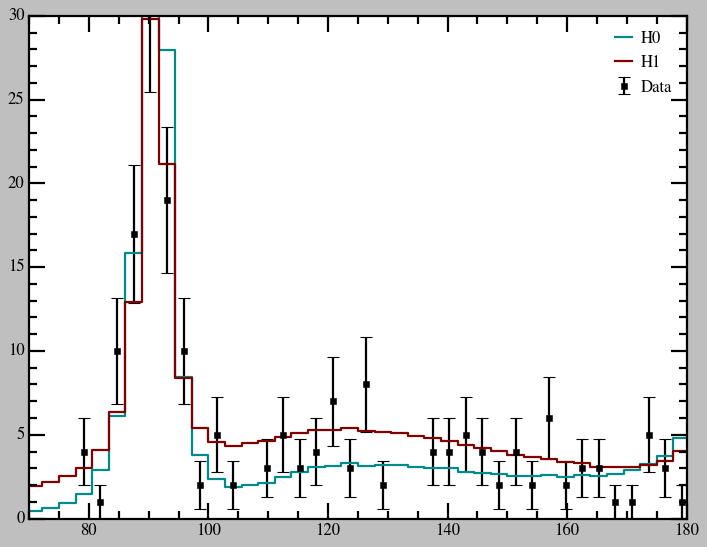

In [47]:
if True:
    fig, ax = plt.subplots(figsize=(9,7))

    mask = nn_observed_hist > 0
    ax.errorbar(bin_centers[mask],nn_observed_hist[mask],yerr=np.sqrt(nn_observed_hist[mask]),
                fmt=' s', markersize=5, elinewidth=2, capsize=5, capthick=1, 
                color='black',label='Data')

    zz_inferred_counts = f_ZZ(np.arange(bin_centers.shape[0]),zz_fitting_result['params'][0])
    higgs_inferred_counts = f_ZZ(np.arange(bin_centers.shape[0]),higgs_fitting_result['params'][0]) + f_Higgs(np.arange(bin_centers.shape[0]),*higgs_fitting_result['params'][1:])

    ax.plot(bin_centers, zz_inferred_counts, drawstyle='steps-mid', color='darkcyan', label='H0')
    ax.plot(bin_centers, higgs_inferred_counts, drawstyle='steps-mid', color='maroon', label='H1')

    ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

    ax.set_xlim(70,180)
    ax.set_ylim(0, 30)

    plt.tight_layout()
    plt.show()

In [48]:
delta_chisqr = zz_fitting_result['chisqr'] - higgs_fitting_result['chisqr']
p_value = 1 - chi2.cdf(delta_chisqr,3)
z_score = - norm.ppf(p_value/2)
print('p-value:',f'{p_value:.02e}')
print('z-score:',f'{z_score:.02f}')

p-value: 1.48e-10
z-score: 6.41


In [58]:
class HiggMassFitter:
    def __init__(self,
                 bin_indices=np.arange(bin_centers.shape[0]),
                 counts=nn_observed_hist,
                 b=None,
                 sigma_mH=sigma_mH,
                 mass_bins=np.linspace(110,160,1000)):
        
        self.bin_indices = bin_indices
        self.counts = counts

        self.b = b
        self.sigma_mH = sigma_mH
        self.mass_bins = mass_bins

        self.p_values = []
        self.z_scores = []
        self.width = []
        for mH in tqdm(self.mass_bins):
            p_value, z_score, width= self._fit_single_mass(mH)

            self.p_values.append(p_value)
            self.z_scores.append(z_score)
            self.width.append(width)

    def _fit_single_mass(self,mH):
        zz_fitter = ZZFitter(
            self.bin_indices,
            self.counts,
            self.b,
        )

        higgs_fitter = HiggsFitter(
            self.bin_indices,
            self.counts,
            self.b,
            mH,
            self.sigma_mH,
        )

        delta_chisqr = zz_fitter.fit()['chisqr'] - higgs_fitter.fit()['chisqr']
        p_value = 1 - chi2.cdf(delta_chisqr,2)
        z_score = - norm.ppf(p_value/2)

        width = higgs_fitter.fit()['params'][3]

        return p_value, z_score, width

In [59]:
higgs_mass_fitter = HiggMassFitter()

100%|██████████| 1000/1000 [00:16<00:00, 61.07it/s]


1.893938812933896


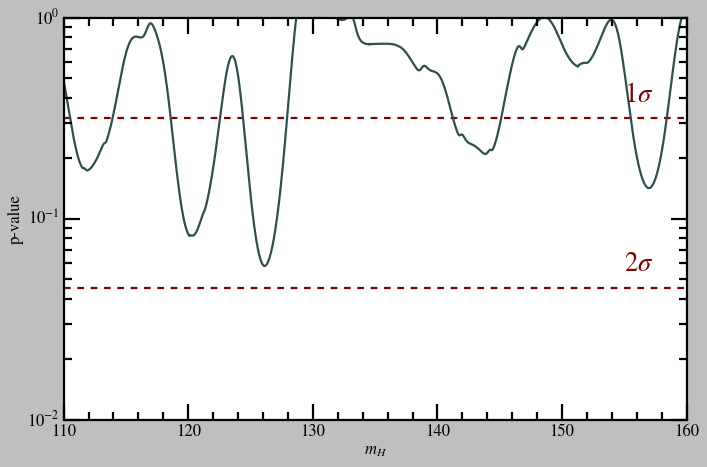

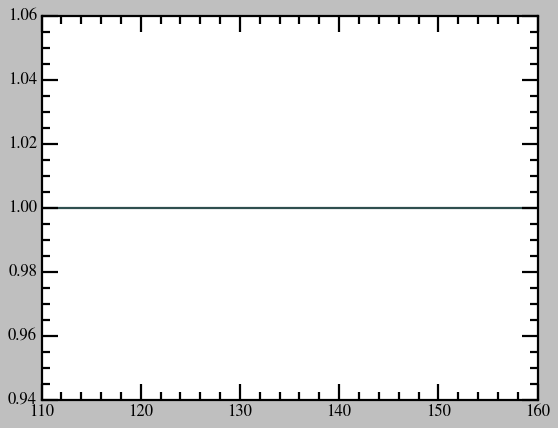

In [60]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(higgs_mass_fitter.mass_bins,higgs_mass_fitter.p_values,color='darkslategrey',zorder=-1)
print(np.max(- norm.ppf(np.array(higgs_mass_fitter.p_values)/2)))

for i in range(1,3):
    p_value = 2*norm.cdf(-i)
    ax.axhline(p_value,ls='--',color='maroon',zorder=-2)
    ax.text(155, 1.3*p_value, rf"${i}\sigma$", fontsize=24, rotation=0, horizontalalignment='left', verticalalignment='center', color='maroon')

ax.set_yscale('log')

ax.set_xlim(110,160)
ax.set_ylim(1e-2,1e0)

ax.set_xlabel(r'$m_H$')
ax.set_ylabel('p-value')

# plt.savefig('p-value.png')

plt.tight_layout()
plt.show()

plt.plot(higgs_mass_fitter.mass_bins,higgs_mass_fitter.width,color='darkslategrey',zorder=-1)